In [1]:
import numpy as np
import pandas as pd
import json
import h5py
import os
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Load evaluation score

In [2]:
def load_eval_scores(model_dir):
    filenames = os.listdir(model_dir)
    
    scores = pd.DataFrame(columns=range(3))
    epochs = pd.DataFrame(columns=range(3))

    idx_regex = re.compile("(\S+)\_(\d)\.h5") # OBS! May need changing

    for run, filename in enumerate(filenames):
        idx_match = idx_regex.search(filename)
        if idx_match is not None:
            idx = idx_match.group(1)
            fld = int(idx_match.group(2))
                        
            #if run > 200:
            fh = h5py.File(model_dir + filename, 'r')
            try:
                scores.loc[idx, fld] = fh["performance"].attrs["optimal_acc"]
                epochs.loc[idx, fld] = len(fh["performance"]["acc"])
            except KeyError:
                fh.close()
                pass
            else:
                fh.close()
                    
    return scores, epochs

## Load hyper-parameter grid

In [3]:
def load_grid(filename, prior=True):
    with open(filename, 'r') as f:
        param_grid = json.load(f)
    
    if prior:
        param_grid.update({u'padding':[u'valid', u'same']})

        filter_dict = dict()
        for i, combination in enumerate(param_grid[u'filters']):
            filter_dict[str(i)] = combination
        param_grid[u'filters'] = list(range(i+1))

        cfs = list()
        for cf in param_grid[u'conv_filters']:
            cfs.append(tuple(cf))
        param_grid[u'conv_filters'] = cfs
        
        return param_grid, filter_dict
    
    else:
        return param_grid

## Frame hyper-parameters

In [4]:
def frame_params(param_directory, parameters, filter_dict):
    import os
    import re
    
    """
    Load all dicts into a df
    Each column is a parameter key
    Each row is a model
    The elements of the dataframe consists of values of each parameters used with that model
    """
    
    idx_regex = re.compile("(\S+)\.json")
    
    param_files = os.listdir(param_directory)
    
    # Define empty dataframe
    df = pd.DataFrame(columns=parameters)
    
    for filename in param_files:
        idx_match = idx_regex.search(filename)
        if idx_match is not None:
            idx = idx_match.group(1)
                        
            param_settings = load_grid(param_directory + filename, prior=False)

            try:
                filters = param_settings.pop(u'filters')
                convflt = param_settings.pop(u'conv_filters')
            except KeyError:
                continue
                pass
            
            try:
                filter_comb = filter_dict.keys()[filter_dict.values().index(filters)]
            except ValueError:
                print(filters)
                print(param_settings)
                continue
                pass

            df.loc[idx, param_settings.keys()] = param_settings.values()
            df.loc[idx, u'padding'] = filters[4]
            df.loc[idx, u'filters'] = filter_comb
            df.at[idx, u'conv_filters'] = tuple(convflt)
            
    return df

## Combine average performance score with parameter frame

In [5]:
def sort_according_to_score(df, scores):
    scores['avg_score'] = scores.mean(axis=1)
    scores['std'] = scores.std(axis=1)
    
    scores.sort_values(by='avg_score', ascending=False, inplace=True)
    
    return df.reindex(scores.index), scores

## Score landscape

In [6]:
def plot_score_landscape(avg_scores, std, upper_bound, lower_bound):
    
    fig = plt.figure(figsize=(20,10))
    
    ind = np.arange(len(avg_scores))
    plt.plot(ind, avg_scores, color='lightblue', label='Mean accuracy')
    plt.fill_between(ind, avg_scores-std, avg_scores+std, alpha=.1)
    plt.xticks(ind[::10], rotation=30, horizontalalignment='right')
    plt.xlabel("models")
    plt.ylabel("scores")
    plt.axvline(upper_bound, color='k', linestyle='dashed')
    plt.axvline(lower_bound, color='k', linestyle='dashed')
    plt.title("Average accuracy score landscape")
    plt.legend(loc='upper right', bbox_to_anchor=(1., 1))
    plt.tight_layout

    plt.savefig("/home/hrp/Master/data/plots/hyperparam_eval/refine/performance_pr_hyperparam_set.png")
    pp = PdfPages("/home/hrp/Master/data/plots/hyperparam_eval/refine/performance_pr_hyperparam_set.pdf")
    pp.savefig()
    pp.close()
    plt.clf()
    plt.cla()
    plt.close()
    
    fig = plt.figure(figsize=(5,3))
    
    ind = np.arange(len(avg_scores))
    plt.plot(ind, avg_scores, color='lightblue', label='Mean accuracy')
    plt.fill_between(ind, avg_scores-std, avg_scores+std, alpha=.1)
    plt.xticks(ind[::50], rotation=30, horizontalalignment='right')
    plt.xlabel("models")
    plt.ylabel("scores")
    plt.axvline(upper_bound, color='k', linestyle='dashed', linewidth=1.0)
    plt.axvline(lower_bound, color='k', linestyle='dashed', linewidth=1.0)
    plt.title("Average accuracy score landscape")
    plt.legend(loc='lower left')#, bbox_to_anchor=(1., 1)
    plt.tight_layout()

    plt.savefig("/home/hrp/Master/data/plots/hyperparam_eval/refine/performance_pr_hyperparam_set_mini.png")
    pp = PdfPages("/home/hrp/Master/data/plots/hyperparam_eval/refine/performance_pr_hyperparam_set_mini.pdf")
    pp.savefig()
    pp.close()
    plt.clf()
    plt.cla()
    plt.close()

In [7]:
def get_priors(df_colnames, param_grid):
    from collections import Counter
    
    expectations = []
    
    for col in df_colnames:
        parameters_exp = sorted(Counter(param_grid[col]).items())
        total = np.sum(Counter(param_grid[col]).values())
        expected = {str(k): [v, v/float(total)] for (k, v) in parameters_exp}
        expectations.append(expected)
        
    return expectations

In [8]:
def define_sample_populations(df_upper, df_lower): 
    from collections import Counter
    
    observations_upper = []
    observations_lower = []
    
    for col in df_upper:
        parameters_obs_up = sorted(Counter(df_upper[col]).items())
        observed_up = {str(k): v for (k, v) in parameters_obs_up}
        observations_upper.append(observed_up)

        parameters_obs_low = sorted(Counter(df_lower[col]).items())
        observed_low = {str(k): v for (k, v) in parameters_obs_low}
        observations_lower.append(observed_low)
    
    return observations_upper, observations_lower

## Bayesian statistics

In [9]:
def infer_binomial_proportions(variable, n_pop1, n_obs1, n_pop2, n_obs2, n_trials=10000, p_hit=0.5, sig_level=0.05):
    """
    Bayesian Analysis inferring two binomial proportions using PyMC.
    
    Arguments:
        n_pop1       Size of first population.
        n_obs1       Observed or counted hits (success) from the first population.
        n_pop2       Size of second population.
        n_obs2       Observed or counted hits (success) from the second population.
        n_trials     Number of trials for binomial simulation. default = 10000.
        p_hit        Probability of success. default = 0.5.
        sig_level    Signinificance level plotted: default = 0.05.
        save_fig     Save output figures in png-format.
    Plots posterior with a 95% confidence interval. 
    If this interval contains 0, then the difference is NOT significant.
    """
    
    import pymc3 as pm
    import scipy as sp
    import scipy.stats as stats
    from scipy.stats import beta
    from scipy.stats import binom
    
    with pm.Model() as model:
        
        # Define the prior (here a binomial distribution as approximation)
        success_freqs = np.random.binomial(n_trials, p_hit, size=n_trials)/float(n_trials)
        # Parameter estimates for generic data
        al, be, loc, scale = sp.stats.beta.fit(success_freqs)
        mean = beta.mean(al, be, loc, scale)
        std = beta.std(al, be, loc, scale)
        print "Generated beta prior with mean: {0} and std: {1}".format(mean, std)
        
        # Expected value of parameters (success frequencies)
        theta1 = pm.Beta('theta1', mu=mean, sd=std)
        theta2 = pm.Beta('theta2', mu=mean, sd=std)
        
        # define the likelihood of estimated parameters given data
        y1 = pm.Binomial("y1", p=theta1, n=n_pop1, observed=n_obs1)
        y2 = pm.Binomial("y2", p=theta2, n=n_pop2, observed=n_obs2)

        # Maximum a posteriori methods (generate a MCMC chain)
        start = pm.find_MAP()  # Find starting value by optimization
        trace = pm.sample(1000, pm.Metropolis(), progressbar=False, cores=1)  # Use Metropolis sampling
        
    pm.traceplot(trace)
    plt.tight_layout
    plt.savefig("/home/hrp/Master/data/plots/hyperparam_eval/refine/hyperparam_trace_" + '_'.join(variable) + ".png")
    pp = PdfPages("/home/hrp/Master/data/plots/hyperparam_eval/refine/hyperparam_trace_" + '_'.join(variable) + ".pdf")
    pp.savefig()
    pp.close()
    plt.clf()
    plt.cla()
    plt.close()
    
    # create an array with the posterior sample
    theta1_sample = trace['theta1']
    theta2_sample = trace['theta2']

    # plot the trajectory of the last 500 sampled values.
    plt.plot(theta1_sample[:-500], theta2_sample[:-500], marker='o',  color='skyblue')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(r'$\theta1$')
    plt.ylabel(r'$\theta2$')

    # display means in plot.
    plt.plot(0, label='means = %.3f, %.3f' % (np.mean(theta1_sample), np.mean(theta2_sample)), alpha=0.0)
    plt.title(' '.join(variable))
    plt.tight_layout
    plt.savefig("/home/hrp/Master/data/plots/hyperparam_eval/refine/hyperparam_trajectory_" + '_'.join(variable) + ".png")
    pp = PdfPages("/home/hrp/Master/data/plots/hyperparam_eval/refine/hyperparam_trajectory_" + '_'.join(variable) + ".pdf")
    pp.savefig()
    pp.close()
    plt.clf()
    plt.cla()
    plt.close()

    # plot a histogram of the posterior differences of theta values.
    theta_diff = theta1_sample - theta2_sample
    pm.plot_posterior(theta_diff, ref_val=0.0, bins=30, color='skyblue', alpha_level=sig_level)
    plt.xlabel(r'$\theta_1 - \theta_2$')
    plt.title(' '.join(variable))
    plt.tight_layout

    plt.savefig("/home/hrp/Master/data/plots/hyperparam_eval/refine/post_diff_hist_" + '_'.join(variable) + ".png")
    pp = PdfPages("/home/hrp/Master/data/plots/hyperparam_eval/refine/post_diff_hist_" + '_'.join(variable) + ".pdf")
    pp.savefig()
    pp.close()
    plt.clf()
    plt.cla()
    plt.close()

# Input arguments

In [10]:
model_dir = "/home/hrp/Master/data/models/3xConv/refine/v0.1/"

In [11]:
param_directory = "/home/hrp/Master/data/grid_search/3xConv/refine/v0.1/"

In [12]:
upper_bound = 50
lower_bound = 150
# Temp
upper_bound = 60
lower_bound = 300

# Main

In [13]:
scores, epochs = load_eval_scores(model_dir)

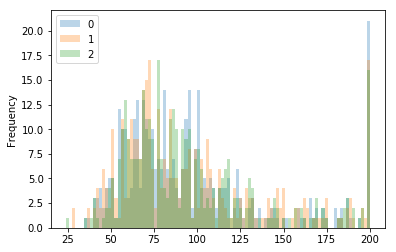

In [14]:
ax = epochs.plot.hist(bins=100, alpha=0.3)

In [15]:
print("0")
print(epochs[0].min())
print(epochs[0].max())
print(epochs[0].mean())
print(epochs[0].mode())
print("1")
print(epochs[1].min())
print(epochs[1].max())
print(epochs[1].mean())
print(epochs[1].mode())
print("2")
print(epochs[2].min())
print(epochs[2].max())
print(epochs[2].mean())
print(epochs[2].mode())
print(epochs.mean())

0
35
200
95.92349726775956
0    200
dtype: object
1
29
200
96.09444444444445
0    200
dtype: object
2
24
200
96.12747875354107
0    200
dtype: object
0    95.923497
1    96.094444
2    96.127479
dtype: float64


In [16]:
param_grid, filter_dict = load_grid(param_directory + 'grid.json')

In [17]:
filter_dict.items()

[('20', [[100, 10], [1, 1], [1, 2], [1, 2], u'valid']),
 ('21', [[100, 5], [1, 1], [1, 2], [1, 2], u'valid']),
 ('22', [[1, 21], [1, 1], [2, 1], [2, 1], u'valid']),
 ('23', [[10, 21], [1, 1], [2, 1], [2, 1], u'valid']),
 ('1', [[10, 5], [10, 1], [1, 2], [1, 2], u'same']),
 ('0', [[10, 10], [10, 1], [1, 2], [1, 2], u'same']),
 ('3', [[10, 5], [5, 1], [1, 2], [1, 2], u'same']),
 ('2', [[10, 10], [5, 1], [1, 2], [1, 2], u'same']),
 ('5', [[10, 5], [2, 1], [5, 2], [1, 2], u'valid']),
 ('4', [[10, 10], [2, 1], [5, 2], [1, 2], u'valid']),
 ('7', [[5, 5], [5, 1], [1, 2], [1, 2], u'same']),
 ('6', [[5, 10], [5, 1], [1, 2], [1, 2], u'same']),
 ('9', [[1, 10], [1, 1], [100, 2], [1, 2], u'valid']),
 ('8', [[1, 10], [1, 1], [100, 2], [1, 2], u'same']),
 ('11', [[1, 5], [1, 1], [100, 2], [1, 2], u'valid']),
 ('10', [[1, 5], [1, 1], [100, 2], [1, 2], u'same']),
 ('13', [[1, 10], [1, 1], [50, 2], [50, 2], u'valid']),
 ('12', [[1, 10], [1, 1], [50, 2], [50, 2], u'same']),
 ('15', [[1, 5], [1, 1], [50,

In [18]:
df = frame_params(param_directory, param_grid.keys(), filter_dict)

[[[10, 10], [10, 1], [1, 2], [1, 2], u'same'], [[10, 5], [10, 1], [1, 2], [1, 2], u'same'], [[10, 10], [5, 1], [1, 2], [1, 2], u'same'], [[10, 5], [5, 1], [1, 2], [1, 2], u'same'], [[10, 10], [2, 1], [5, 2], [1, 2], u'valid'], [[10, 5], [2, 1], [5, 2], [1, 2], u'valid'], [[5, 10], [5, 1], [1, 2], [1, 2], u'same'], [[5, 5], [5, 1], [1, 2], [1, 2], u'same'], [[1, 10], [1, 1], [100, 2], [1, 2], u'same'], [[1, 10], [1, 1], [100, 2], [1, 2], u'valid'], [[1, 5], [1, 1], [100, 2], [1, 2], u'same'], [[1, 5], [1, 1], [100, 2], [1, 2], u'valid'], [[1, 10], [1, 1], [50, 2], [50, 2], u'same'], [[1, 10], [1, 1], [50, 2], [50, 2], u'valid'], [[1, 5], [1, 1], [50, 2], [50, 2], u'same'], [[1, 5], [1, 1], [50, 2], [50, 2], u'valid'], [[1, 10], [1, 1], [50, 2], [25, 2], u'same'], [[1, 10], [1, 1], [50, 2], [25, 2], u'valid'], [[1, 5], [1, 1], [50, 2], [25, 2], u'same'], [[1, 5], [1, 1], [50, 2], [25, 2], u'valid'], [[100, 10], [1, 1], [1, 2], [1, 2], u'valid'], [[100, 5], [1, 1], [1, 2], [1, 2], u'valid

In [19]:
df, scores = sort_according_to_score(df, scores)

In [20]:
df.head(20)

,dense_activation_func,batch_size,dense_dim,padding,conv_pooling,conv_activation_func,filters,conv_filters
c719a088-6dbf-47d9-85fd-6481d2422fdc,swish,1024,32,valid,max,tanh,22,"(50, 30, 10)"
1bb71b5b-e583-495e-877d-03db4c55f9d0,swish,1024,32,valid,max,tanh,22,"(30, 30, 30)"
09db1f5c-251b-40ed-90eb-a64125d081ce,swish,1024,32,valid,max,tanh,22,"(30, 30, 30)"
94270d71-bdeb-48a3-8283-7166fef3ea91,swish,1024,16,valid,max,tanh,22,"(30, 30, 30)"
37063097-97f7-4d98-966a-497f5b088441,swish,1024,32,valid,max,tanh,22,"(30, 30, 30)"
8c5b2e42-3f74-4b62-8795-6e9d98714e86,swish,1024,16,valid,avg,tanh,22,"(50, 30, 10)"
87600cb6-a259-4d9e-8aa9-e8d40e544937,swish,1024,32,valid,max,tanh,22,"(30, 30, 30)"
de9f9149-39e1-4231-b316-3d0043a864f9,swish,1024,32,valid,max,tanh,22,"(30, 20, 10)"
ae30d30b-0d0b-473b-8520-5b82489add2e,swish,1024,16,same,max,tanh,16,"(30, 20, 10)"
a22775e7-1cdf-4c1f-a5ab-06ccd2d302be,swish,1024,16,valid,max,tanh,22,"(50, 30, 10)"


In [21]:
print(scores["avg_score"].max())
print(scores["avg_score"].min())
print(len(scores["avg_score"]))

0.9898588085009851
0.9170959156411918
366


In [22]:
plot_score_landscape(np.array(scores["avg_score"].astype(float)), np.array(scores["std"].astype(float)), upper_bound, lower_bound)

In [ ]:
expectations = get_priors(df.columns, param_grid)

In [ ]:
df_upper = df.head(upper_bound)
df_lower = df.tail(len(df) - lower_bound)

In [ ]:
observations_upper, observations_lower = define_sample_populations(df_upper, df_lower)

In [ ]:
assert len(expectations)==len(observations_lower)==len(observations_upper)

In [ ]:
for i in range(len(df.columns)):
    for key in expectations[i]:
        print df.columns[i], key
        p_prior = np.round(expectations[i][key][1], 3)
        print "prior probability: ", p_prior
        
        try:
            obs_up = observations_upper[i][key]
        except KeyError:
            obs_up = 0
        try:
            obs_low = observations_lower[i][key]
        except KeyError:
            obs_low = 0
            
        print "upper: {0}/{1} ({2}), lower: {3}/{4} ({5})".format(obs_up, len(df_upper), obs_up/float(len(df_upper)), obs_low, len(df_lower), obs_low/float(len(df_lower)))
        
        infer_binomial_proportions(variable=[df.columns[i], key],
                                   n_pop1=len(df_upper), 
                                   n_obs1=obs_up, 
                                   n_pop2=len(df_lower), 
                                   n_obs2=obs_low, 
                                   n_trials=len(df), 
                                   p_hit=p_prior,
                                   sig_level=0.1)

In [ ]:
1/16.0

In [ ]:
3**8

In [ ]:
230/6561.0

In [ ]:
4*4*3*3*4*2*2*2

In [ ]:
230/4608.0

In [ ]:
40000*0.04991319444444445

In [ ]:
2*3*2*24

In [ ]:
import random
from itertools import product

a = [0.1,0.2,0.3]
b = dict(lr=a)
grid = list(product(*b.values()))
print(grid)
a[random.sample(range(len(a)),1)[0]]

In [ ]:
1/8.0